[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rycroft-group/math513/blob/main/1_svd/eigenleaf.ipynb)

In [1]:
# Necessity libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from copy import deepcopy

# Optional: a library for plotting with LaTeX-like 
# styles nicer formatted figures
# Warning: need to have LaTeX installed
import scienceplots
plt.style.use(['science'])

# Eigenleaf

The eigenleaf example was originally created by Chris Rycroft for Harvard AM205. This notebook shows the steps to perform PCA/SVD on the New Hampshire leaf dataset.

## The New Hampshire leaf dataset

New England is world famous for its fall foliage. From late September to early November, the trees throughout the region display an impressive range of autumnal hues.

On one trip, Chris and his friends collected $L = 143$ leaves near the White Mountains in New Hampshire. The leaves were systematically photographed, and they were rotated and scaled so that their bases and tips were in the same location. Some samples are shown below.

![Leaf montage](figs/leaf_montage.png)

These images are available on the website as a separate download. There are three sizes available for $(m, n) \in {(712, 560),(534, 420),(356, 280)}$. Select one set of images to use.

## Subtractive color mixing

We are going to employ [subtractive color mixing](https://en.wikipedia.org/wiki/Subtractive_color) for pre-processing these colored leaf data.

Normally, pixel colors on a computer are represented as $\mathbf{p}=(R,G,B)$ using additive color mixing: The base color is black, and the red ($R$), green ($G$), and blue ($B$) components are added to it.

For subtractive color mixing, a pixel is represented using $\mathbf{s}=(C,M,Y)$: We instead start from white, and then cyan ($C$), magenta ($M$), and yellow ($Y$) components are subtracted from it. This is often used in color printing and photography.

If $1$ represents the maximum color intensity, then the two representations are related via the formula
\begin{equation}
\mathbf{s} = (1, 1, 1) - \mathbf{p}.
\end{equation}

Throughout this example, we will make use of pixel colors in the $\mathbf{s}$ representation (i.e., for each image in the leaf dataset). We will only need to use Eq.(1) to perform a conversion when we read in files, and when we output images.

## Average leaf

Let each leaf photo be represented by a column vector $\mathbf{S}_j$ of length $3mn$ containing all the pixel color channels in the subtractive presentation. We will first compute the average leaf vector $\overline{\mathbf{S}} = \frac{1}{L}\sum_j\mathbf{S}_j$ and plot it as an image.

### Load image function

First, let us define a function to load in the RGB image. We will convert the RGB values to $[0,1]$ scale in order to perform arithmetic.

In [2]:
def load_image(fname):
    """Load an image from file and normalize RGB pixel values to [0,1].
    Input:
        fname: string, path to the image file
    Output:
        p: a 3D numpy array of shape (m,n,3) representing the RGB image
    """
    A = imread(fname)
    p = A.astype(np.float64)/255.
    return p

### Color conversion function

First, let us write two functions: One to convert the RGB additive color representation to the CMY subtractive color representation; the other vice versa.

In [3]:
def rgb2cmy(p):
    """Convert an RGB image to CMY color space.
    Input:
        p: a 3D numpy array of shape (m,n,3) representing an RGB image
    Output:
        s: a 3D numpy array of shape (m,n,3) representing the CMY image
    """
    s = 1 - p
    return s

def cmy2rgb(s):
    """Convert a CMY image to RGB color space.
    Input:
        s: a 3D numpy array of shape (m,n,3) representing a CMY image
    Output:
        p: a 3D numpy array of shape (m,n,3) representing the RGB image
    """
    p = 1 - s
    return p

### Compute the average leaf

Let us read in the 143 leaf files, convert it to CMY, and compute the average leaf.

In [4]:
# Select case: 0 (large), 1 (medium), 2 (small)
case = 1
# Set image dimensions and total images
(m, n) = [(712, 560), (534, 420), (356, 280)][case]
# Length of the column vectorized image
sz = m*n*3
dimstr = "%dx%d" % (m, n)
nleaf = 143

# Initialize matrices, and fill with leaf data
A = np.zeros((sz, nleaf))  # this will be our mean-subtracted data matrix (in CMY)
Sbar = np.zeros((sz))  # average leaf (in CMY)

# Loop over all leaf images
for i in range(nleaf):
    # Load one leaf image (RGB space and normalized)
    p = load_image("figs/leaves_%s/main/leaf%03d.png" % (dimstr, i))
    # Convert to CMY space
    s = rgb2cmy(p)
    # Reshape to column vector and store
    d = s.reshape((sz))
    A[:, i] = d
    Sbar[:] += d

# Compute average leaf (in CMY)
Sbar *= 1/float(nleaf)
# Optional save
# np.save('results/avg'+dimstr, Sbar)

### Plot the average leaf

To visualize the average leaf, we need to convert the average leaf that we just computed, which is in CMY space, first, back to a 3D array $(m,n,3)$, and then back to RGB for plotting.

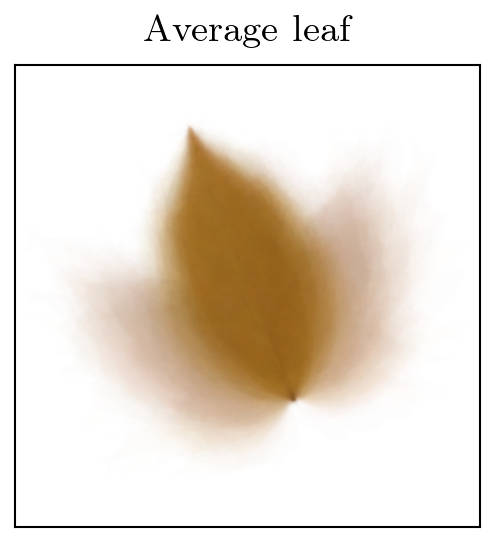

In [5]:
# Reshape the average leaf to (m,n,3) for plotting
# and convert back to RGB for display
Pbar = cmy2rgb(Sbar.reshape((n, m, 3)))

fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
ax.imshow(Pbar)
ax.set_title('Average leaf', fontsize=9)
# Prettify
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# plt.savefig("results/eigenleaf_average_%s.pdf" % dimstr, bbox_inches='tight', transparent=True)
plt.show()

## Reduced SVD and singular vectors

Assemble a matrix $A$ of size $3mn \times L$ where each column $A_{(:,j)}$ is given by $\mathbf{S}_j - \overline{\mathbf{S}}$. Perform the reduced SVD of $A$, so that $A=\widehat{U}\widehat{\Sigma} V^{\mathsf{T}}$. Note that it is important to do the reduced not the full SVD. Otherwise, the matrix $U$ will have size $3mn \times 3mn$, which will likely overload our computers' memory.

In [6]:
# Subtract average leaf from all leaves
for i in range(nleaf):
    A[:, i] -= Sbar

# Reduced SVD
U, s, Vt = np.linalg.svd(A, full_matrices=0)
# Optional save of first 16 left singular vectors
# np.save('results/svd'+dimstr, U[:,0:16])

The left singular vectors may have positive and negative components. Define $c_j=\min_i u_{i,j}$ and $d_j=\max_i u_{i,j}$, where we expect that in general $c_j < 0 < d_j$. From here, we define scaled positive and negative components as
$$
u_{i,j}^P = \max\left\{0, \frac{u_{i,j}}{d_j}\right\}, u_{i,j}^N = \max\left\{0, \frac{u_{i,j}}{c_j}\right\},
$$
respectively.

With that, we plot $u_{i,j}^P$ and $u_{i,j}^N$ for $j=1,2,3$, the positive and negative components to the first three left singular vectors, $u_1, u_2$, and $u_3$.

### Compute positive and negative components

First, let us define two functions to compute the positive components and negative components of a left singular vector.

In [7]:
def positive_component(u):
    """Return the positive component of a left singular vector.
    Input:
        u: column vector (left singular vector)
    Output:
        up: positive component of u
    """
    up = np.zeros_like(u) # initialize positive component
    dj = np.amax(u) # maximum value in u
    # Compute positive component
    up = u / dj
    up[up < 0.] = 0. # cap values at 0
    up[up > 1.] = 1. # cap values at 1
        
    return up

In [8]:
def negative_component(u):
    """Return the negative component of a left singular vector.
    Input:
        u: column vector (left singular vector)
    Output:
        up: negative component of u
    """
    un = np.zeros_like(u) # initialize negative component
    cj = np.amin(u) # maximum value in u
    # Compute negative component
    un = u / cj
    un[un < 0.] = 0. # cap values at 0
    un[un > 1.] = 1. # cap values at 1
        
    return un

### Plot for the first three left singular vectors

Then, let us plot the positive and negative components of the first three left singular vectors.

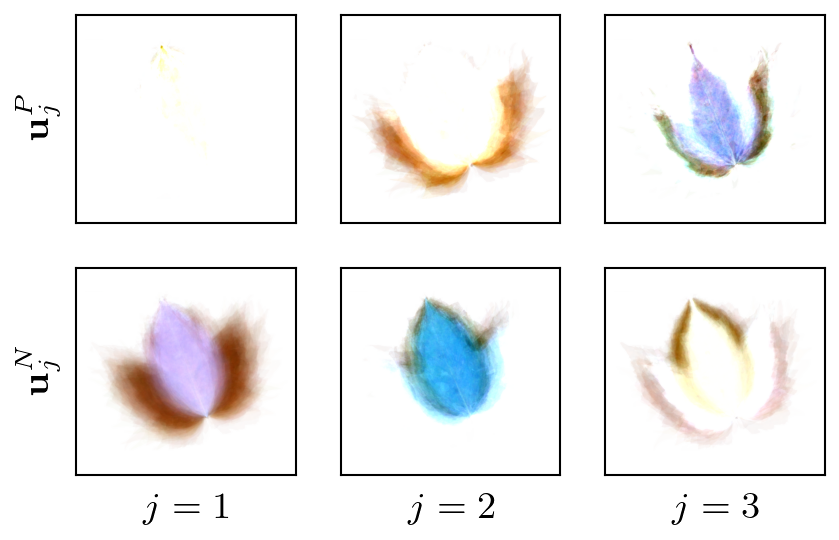

In [9]:
# Number of singular vectors to plot
num_vectors = 3

fig, axes = plt.subplots(2, num_vectors, figsize=(3, 2), dpi=300)

for i in range(num_vectors):
    u = U[:, i] # left singular vector

    # Positive components
    up = positive_component(u)
    # Reshape the singular vector to (m, n, 3) for plotting
    # and convert back to RGB for display
    axes[0, i].imshow(cmy2rgb(up.reshape((n, m, 3))))

    # Negative components
    un = negative_component(u)
    # Reshape the singular vector to (m, n, 3) for plotting
    # and convert back to RGB for display
    axes[1, i].imshow(cmy2rgb(un.reshape((n, m, 3))))

# Formatting
axes[0, 0].set_ylabel('$\mathbf{u}_j^P$', fontsize=9)
axes[1, 0].set_ylabel('$\mathbf{u}_j^N$', fontsize=9)
axes[1, 0].set_xlabel('$j=1$', fontsize=9)
axes[1, 1].set_xlabel('$j=2$', fontsize=9)
axes[1, 2].set_xlabel('$j=3$', fontsize=9)

# Prettify
for ax in axes.flatten():
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.tight_layout()
plt.show()

The form of $\mathbf{u}_1$ is reasonable, since the data set contains a large number of elliptical shaped leaves, plus a large number of maple leaves. For some constant $\beta>0$, the image of $\overline{S}-\beta\mathbf{u}_1$ will look like a maple leaf, while the image $\overline{S}+\beta\mathbf{u}_1$ will look like a leaf with an elliptical shape. Hence this vector will likely explain a large amount of the variance in the data set.

## Approximate leaf representation

We further investigate the use of the eigenleaves as a coordinate system. By projection an image $\mathbf{T}$ onto the first $r$ PCA modes, we obtain a set of coordinates in this space. Note that this is a subspace centered on $\overline{S}$ and spanned by the first $r$ left singular vectors.

For a given image $\mathbf{T}$ interpreted as a column vector, we define the projection operator to be
$$
\mathbb{P}(\mathbf{T}, r) = \overline{\mathbf{S}} + \sum\limits_{j=1}^r \left[ u_{(:,j)}^\mathsf{T} (\mathbf{T}-\overline{{\mathbf{S}}})\right] u_{(:,j)}.
$$
In other words, $\mathbb{P}(\mathbf{T}, r)$ is the closest point projection of the image $\mathbf{T}$ onto the subspace. We can use this projection as a way to approximate representation of a leaf image.

### Projection function

First, let us define a function to do the projection

In [10]:
def projection(T, r, Sbar, U):
    """Project image T onto rank r approximation.
    Input:
        T: input image (column vector)
        r: target rank
        Sbar: average leaf
        U: left singular vectors
    Output:
        Tr: rank r approximation of T
    """
    TminusSbar = T - Sbar
    proj_T = deepcopy(Sbar) # initialize projection column vector
    # Note: We cannot use U @ U.T @ TminusSbar directly U @ U.T is too large
    for j in range(r):
        uj = U[:, j]
        coeff = uj.T @ TminusSbar
        proj_T += coeff * uj
    
    return proj_T

### Perform the projection of some leaf images in the dataset

We pick leaf 14, 33, 87, and 140 and use $r=1, 2, 4, 8, 16$.

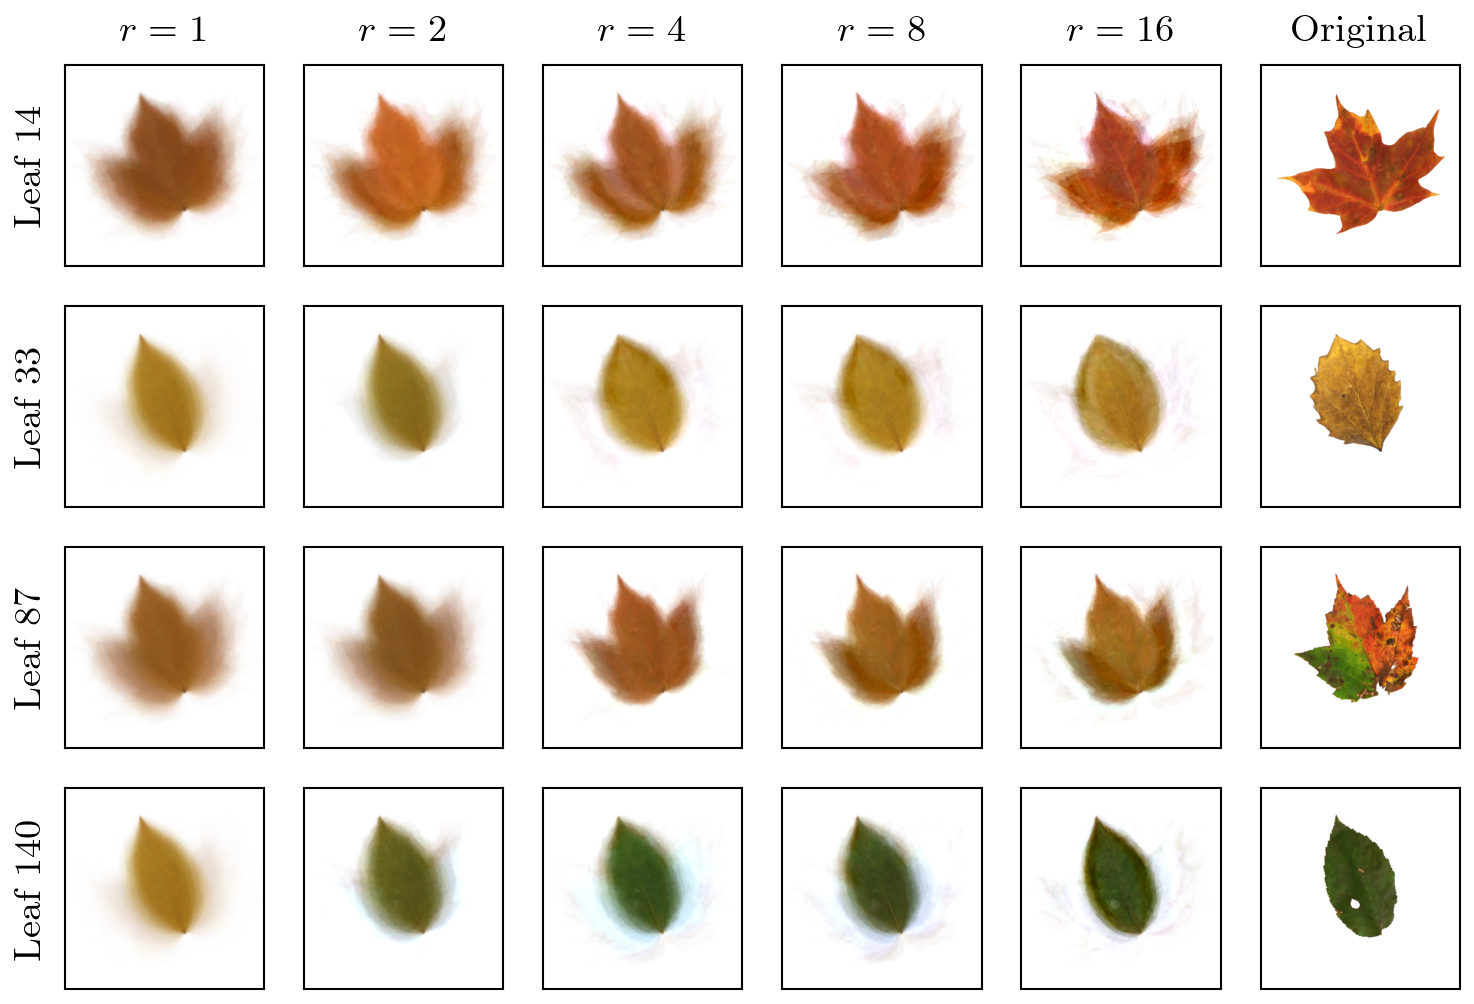

In [11]:
ranks = [1, 2, 4, 8, 16]
leafids = [14, 33, 87, 140]

fig, axes = plt.subplots(len(leafids), len(ranks)+1, figsize=(6, 4), dpi=300)
for i, leafid in enumerate(leafids):
    # Load one leaf image (RGB space and normalized)
    p = load_image("figs/leaves_%s/main/leaf%03d.png" % (dimstr, leafid))
    # Convert to CMY space
    s = rgb2cmy(p)
    # Reshape to column vector and store
    d = s.reshape((sz)) # this is T

    # Plot original leaves in the last column
    axes[i, -1].imshow(p)

    # Compute and plot the projections
    for j, r in enumerate(ranks):
        # Project onto rank r approximation
        proj_T = projection(d, r, Sbar, U)
        # Clip values to [0,1]
        proj_T[proj_T < 0.] = 0.
        proj_T[proj_T > 1.] = 1.
        # Reshape back to (m,n,3) for plotting
        # and convert back to RGB for display
        Tr = cmy2rgb(proj_T.reshape((n, m, 3)))
        # Plot
        axes[i, j].imshow(Tr)

# Formatting
for j, r in enumerate(ranks):
    axes[0, j].set_title('$r = %d$' % r, fontsize=9)
for i, leafid in enumerate(leafids):
    axes[i, 0].set_ylabel('Leaf %d' % leafid, fontsize=9)
axes[0, -1].set_title('Original', fontsize=9)

# Prettify
for ax in axes.flatten():
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

## Principal components

We demonstrate how to use principal components as coordinate systems to visualize and/or classify data.

### Perform the projection onto PC1 and PC2

In [12]:
# Project all leaves onto the first two principal components
pc1 = U[:, 0]  # First principal component
pc2 = U[:, 1]  # Second principal component

# Compute the projections
# Reminder: A is the mean-subtracted data matrix
projections = np.dot(A.T, np.vstack((pc1, pc2)).T)

# Extract the coordinates for plotting
x_coords = projections[:, 0]  # Projections onto PC1
y_coords = projections[:, 1]  # Projections onto PC2

### Visualize all leaf data on PC1 and PC2

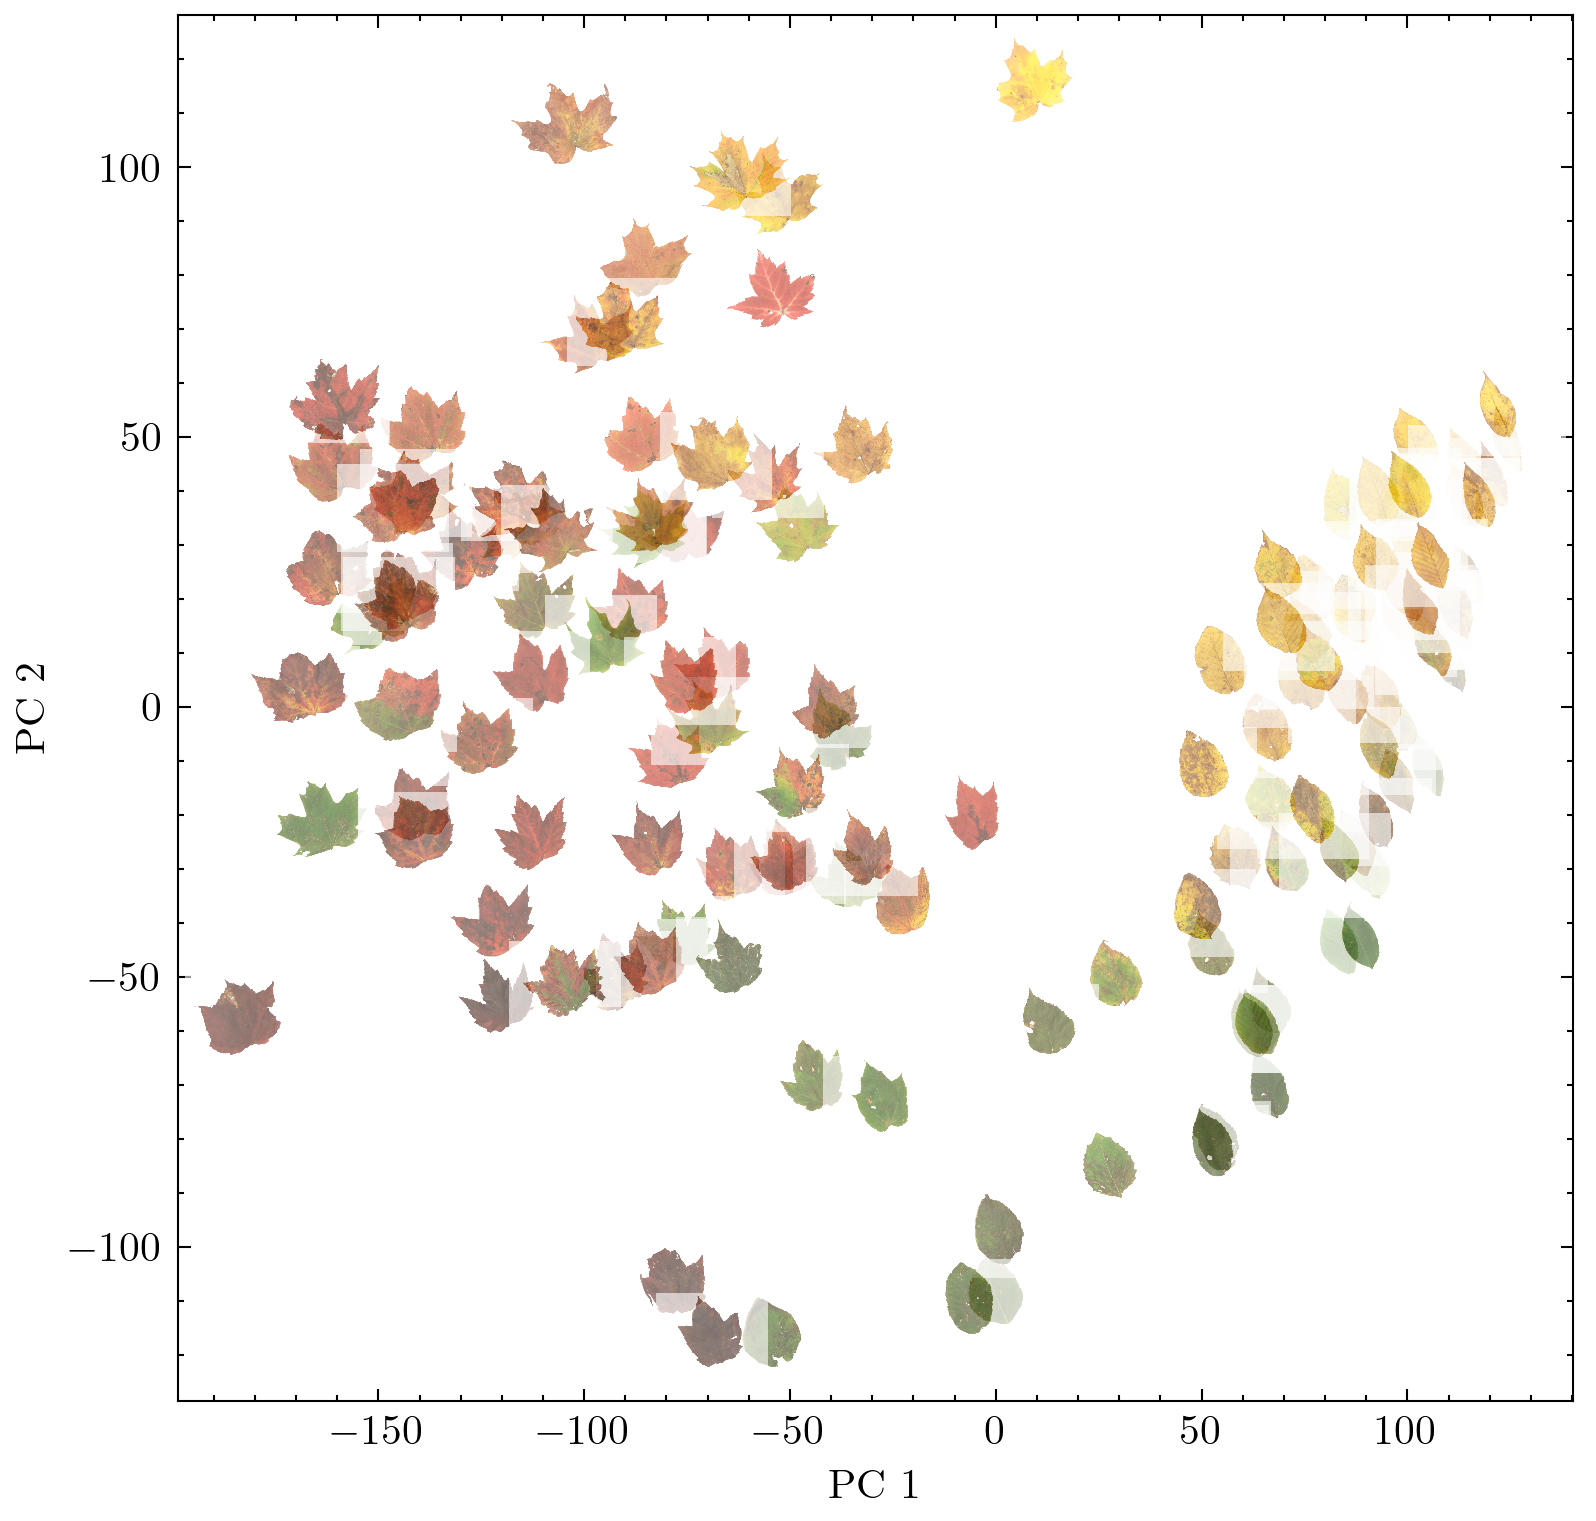

In [13]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Plot the projections
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
ax.scatter(x_coords, y_coords, c='k', alpha=0.0, edgecolors='w', zorder=0)

# Add an inset to plot a leaf
for i in range(len(x_coords)):
    leaf_image = cmy2rgb((A[:, i] + Sbar).reshape((n, m, 3)))
    oi = OffsetImage(leaf_image, zoom=0.05, alpha=0.6)

    ab = AnnotationBbox(
        oi,
        (x_coords[i], y_coords[i]),
        frameon=False,
        box_alignment=(0.5, 0.5)
    )
    ax.add_artist(ab)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

plt.show()